In [1]:
from IPython.display import clear_output
from collections import deque, namedtuple
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from minesweeper import Minesweeper
from mineRL import Agent, DQN
from utils import decrease_epsilon, plot_result

import time

gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(gpu)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

memory = ReplayMemory(1000000)

num_mine = 10; sizeX = 8; sizeY = 8
l_rate = 0.0001

game = Minesweeper(num_mine=num_mine, sizeX=sizeX, sizeY=sizeY)
agent = Agent(sizeX=sizeX, sizeY=sizeY, l_rate=l_rate, gpu=gpu)

num_episode = 5
epsilon = 0.99
gamma = 0.95

batch_size = 256
target_update = 50 

sim = 0
sim_limit = 10000



sim_plot = []
rd_mean_plot_tr = []
rd_mean_plot_ts = []
rd_mean_plot_smooth_tr = []
rd_mean_plot_smooth_ts = []

cpu


sim: 4750
========== TRAIN ==========


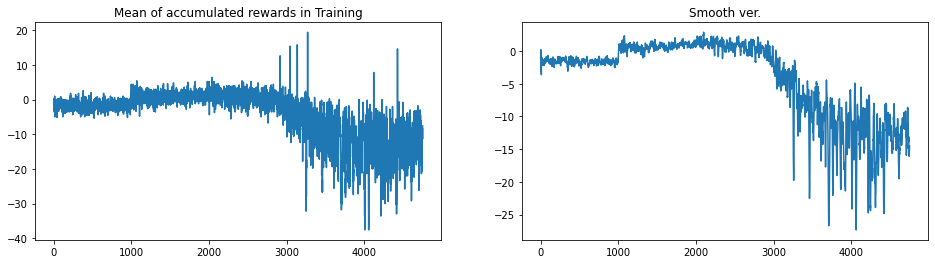

========== TEST ==========


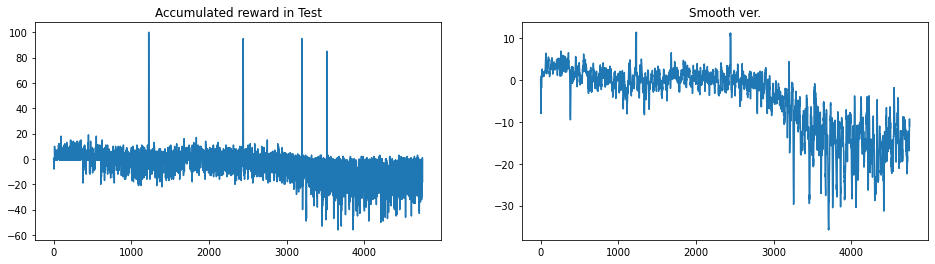

KeyboardInterrupt: 

In [2]:
while sim < sim_limit:
    #start_time = time.time()
    # target update
    if sim % target_update == 0:
        agent.update()

    # TRAIN - Exploration
    agent.mainDQ.train()

    acc_rds = []
    for ep in range(num_episode):
        game.new_game(num_mine, sizeX, sizeY)
        done, turn = 0, 0
        acc_rd = 0
        
        while not done:
            turn += 1

            state = torch.Tensor(game.get_state()).unsqueeze(dim=0).unsqueeze(dim=0).to(gpu)
            mask  = torch.Tensor(game.action_mask()).to(gpu)
            num, Q = agent.choose(epsilon, state, mask, learn=True)
            reward, done = game.action(num)
            reward = torch.Tensor([reward]).to(gpu)
            acc_rd = acc_rd + reward

            if not done:
                next_state = torch.Tensor(game.get_state()).unsqueeze(dim=0).unsqueeze(dim=0).to(gpu)
            else:
                next_state = None

            memory.push(state, num, next_state, reward)

        acc_rds.append(acc_rd)

    #episode_time = time.time()

    # Train - Optimize
    if len(memory) > batch_size:
        transitions = memory.sample(batch_size)
        batch = Transition(*zip(*transitions))

        # if non_final transition(next_state != None): True
        # if final transition (next_state == None): False
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=gpu, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Q(s_t, a_t)
        state_action_values = agent.mainDQ(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(batch_size, device=gpu)
        next_state_values[non_final_mask] = agent.tarDQ(non_final_next_states).max(1)[0].detach()

        # (reward + gamma * max_a{Q(s',a)})
        expected_state_action_values = (next_state_values * gamma) + reward_batch

        loss = agent.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        agent.opt_mainDQ.zero_grad()
        loss.backward()
        agent.opt_mainDQ.step()

    #optimize_time = time.time()

    # TEST
    agent.mainDQ.eval()

    game.new_game(num_mine, sizeX, sizeY)
    done, turn = 0, 0
    acc_rd = 0

    while not done:
        turn += 1

        state = torch.Tensor(game.get_state()).unsqueeze(dim=0).unsqueeze(dim=0).to(gpu)
        mask = torch.Tensor(game.action_mask()).to(gpu)
        num, Q = agent.choose(epsilon, state, mask, learn=False)
        reward, done = game.action(num)
        reward = torch.Tensor([reward]).to(gpu)
        acc_rd = acc_rd + reward

    #test_time = time.time()

    if sim % 50 == 0:
        clear_output()
        sim_plot, rd_mean_plot_tr, rd_mean_plot_smooth_tr = plot_result(True, True, sim, acc_rds, sim_plot, rd_mean_plot_tr, rd_mean_plot_smooth_tr)
        sim_plot, rd_mean_plot_ts, rd_mean_plot_smooth_ts = plot_result(False, True, sim, acc_rd, sim_plot, rd_mean_plot_ts, rd_mean_plot_smooth_ts)
    else:
        sim_plot, rd_mean_plot_tr, rd_mean_plot_smooth_tr = plot_result(True, False, sim, acc_rds, sim_plot, rd_mean_plot_tr, rd_mean_plot_smooth_tr)
        sim_plot, rd_mean_plot_ts, rd_mean_plot_smooth_ts = plot_result(False, False, sim, acc_rd, sim_plot, rd_mean_plot_ts, rd_mean_plot_smooth_ts)
    
    epsilon = decrease_epsilon(epsilon, sim, 1000)

    #plot_time = time.time()
    #if sim % 50 == 0:
        #print(f'episode time: {episode_time - start_time}')
        #print(f'optimize time: {optimize_time - episode_time}')
        #print(f'test time: {test_time - optimize_time}')

    sim += 1

In [5]:
game.get_state()

array([[ 0.,  0.,  0.,  0.,  1., -1., -1., -5.],
       [ 0.,  0.,  0.,  1.,  2.,  2., -1., -1.],
       [ 0.,  0.,  0.,  2., -1., -1.,  1., -1.],
       [ 0.,  0., -1.,  2., -1.,  3.,  1., -1.],
       [ 0.,  0.,  0.,  2.,  3., -1.,  2., -1.],
       [-1.,  1.,  1.,  2., -1., -1.,  2., -1.],
       [-1.,  1., -1.,  2.,  1.,  2., -1., -1.],
       [-5., -1., -1.,  1.,  0.,  1., -1., -5.]])

In [6]:
num

tensor(90)

In [7]:
game.win, game.dead

(0, 0)

In [8]:
Q

tensor([[ 5959.3730,  8679.3213,  9745.0889,  9477.1074,  9439.3604,  9940.9316,
          9443.2930,  7147.8516,  8789.5967, 11442.0996, 11127.2471,  9154.4600,
          8688.5537, 10373.2090, 11097.0488,  9552.6553, 10944.1943, 13458.8652,
         12105.1230,  9014.0322,  7794.8789,  9919.9434, 11594.4932, 10908.6084,
         12247.4932, 14527.5625, 12506.4922,  8735.2520,  7352.5503,  9512.2539,
         11703.4844, 11435.4766, 12184.7109, 13805.0156, 11256.0283,  7327.5874,
          6237.0190,  8425.4521, 11326.3340, 11289.6660, 11146.3398, 12541.4014,
         10178.9346,  6755.7041,  6022.0869,  8592.5762, 11370.9707, 10892.3457,
          9721.4961, 11649.1582, 10573.4688,  8707.5469,  8387.0898, 10204.2969,
         11327.6074,  9910.0020,  7331.6606, 10190.8877, 11283.3340, 11212.9678,
         11158.1924, 11297.9248, 10509.4004,  7780.6768,  8417.9678, 12622.4922,
         14727.3125, 15041.8213, 15123.9648, 15093.1143, 13388.6895,  9512.0713,
         12271.5283, 17173.9